In [1]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pickle
import pandas as pd
import numpy as np
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate

**Load Preprocessed Data**





In [4]:
movies_df = pd.read_csv("./CleanedData/movies_cleaned.csv") 
ratings_df = pd.read_csv("./CleanedData/ratings_cleaned.csv")

**Load Saved Models**





In [6]:
with open("./Pickle/cosine_sim.pkl", 'rb') as f:
    cosine_sim = pickle.load(f)

with open("./Pickle/indices.pkl", 'rb') as f:
    indices = pickle.load(f)

with open("./Pickle/svd_model.pkl", 'rb') as f:
    svd = pickle.load(f)

print(" Loaded cosine similarity matrix, movie indices, and SVD model successfully!")

 Loaded cosine similarity matrix, movie indices, and SVD model successfully!


Load dataset into Surprise format for Collaborative Filtering

In [8]:
# Load dataset into Surprise format for collaborative filtering
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
trainset = data.build_full_trainset()

# Tune SVD model using cross-validation
svd = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
svd.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8984  0.9007  0.8915  0.8899  0.8999  0.8961  0.0045  
MAE (testset)     0.6933  0.6945  0.6846  0.6854  0.6918  0.6899  0.0041  
Fit time          0.67    0.69    0.56    0.59    0.55    0.61    0.06    
Test time         0.08    0.16    0.08    0.13    0.07    0.10    0.04    


**Hybrid Recommendation Function**

In [10]:
from sklearn.preprocessing import MinMaxScaler

def hybrid_recommend(user_id, movie_title, alpha=0.5, num_recommendations=10):
    """
    Generate hybrid recommendations using content-based filtering (cosine similarity)
    and collaborative filtering (SVD). Alpha controls the balance (0-1).
    """
    movie_title = movie_title.lower().strip()

    if movie_title not in indices:
        print(f"Movie title '{movie_title}' not found in dataset.")
        return pd.DataFrame(columns=['title', 'genres', 'release_year'])

    # 1️⃣ Content-Based Recommendations
    idx = indices[movie_title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:num_recommendations+15]  # Extra movies to filter later
    content_recs = {movies_df.iloc[i[0]].movieId: i[1] for i in sim_scores}

    # Apply feature weighting to improve similarity
    for movie_id in content_recs:
        content_recs[movie_id] *= 1.2  # Give slightly more weight to content-based scores

    # 2️⃣ Collaborative Filtering Recommendations (Predicted Ratings from SVD)
    all_movie_ids = movies_df['movieId'].unique()
    rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].tolist()

    predicted_ratings = {}
    for movie_id in all_movie_ids:
        if movie_id not in rated_movies:
            pred = svd.predict(user_id, movie_id)
            if pred.est >= 3.0:  # Ignore low ratings
                predicted_ratings[movie_id] = pred.est

    # 3️⃣ Normalize Content & Collaborative Scores Separately
    def normalize_scores(score_dict):
        if not score_dict:
            return {}
        values = np.array(list(score_dict.values())).reshape(-1, 1)
        scaler = MinMaxScaler()
        normalized_values = scaler.fit_transform(values).flatten()
        return {k: v for k, v in zip(score_dict.keys(), normalized_values)}

    content_recs = normalize_scores(content_recs)
    predicted_ratings = normalize_scores(predicted_ratings)

    # 4️⃣ Compute Hybrid Scores (Adaptive Weighting)
    hybrid_scores = {}
    for movie_id in set(content_recs.keys()).union(set(predicted_ratings.keys())):
        content_score = content_recs.get(movie_id, 0)
        collab_score = predicted_ratings.get(movie_id, 0)
        hybrid_scores[movie_id] = alpha * content_score + (1 - alpha) * collab_score

    # 5️⃣ Get Top Recommendations
    sorted_movies = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:num_recommendations]
    recommended_movie_ids = [i[0] for i in sorted_movies]

    return movies_df[movies_df['movieId'].isin(recommended_movie_ids)][['title', 'genres', 'release_year']]


In [11]:
# Example usage
recommendations = hybrid_recommend(user_id=1, movie_title="Toy Story", alpha=0.8, num_recommendations=10)
print(recommendations)

                                  title  \
1898                                Big   
2082                        Toy Story 2   
2240                  Creature Comforts   
2672           The Million Dollar Hotel   
5248   Torrente The Dumb Arm Of The Law   
6891                     License To Wed   
8852                        Toy Story 3   
12015               Toy Story Of Terror   
13691        Toy Story That Time Forgot   
17996                   The Adopted Son   

                                        genres  release_year  
1898   ['fantasy,drama,comedy,romance,family']          1988  
2082               ['animation,comedy,family']          1999  
2240               ['animation,comedy,family']          1989  
2672                        ['drama,thriller']          2000  
5248                          ['comedy,crime']          1998  
6891                                ['comedy']          2007  
8852               ['animation,family,comedy']          2010  
12015              ['a

In [12]:
# Example: Recommend movies for User 1 based on "Avatar"
hybrid_recommend(user_id=1, movie_title="Avatar", alpha=0.7, num_recommendations=5)

,title,genres,release_year
2672,The Million Dollar Hotel,"['drama,thriller']",2000
11498,Star Trek Into Darkness,"['action,adventure,sciencefiction']",2013
11724,Arena,"['horror,sciencefiction']",1989
13961,Avatar 2,"['action,adventure,fantasy,sciencefiction']",2020
14709,Transmorphers,"['action,adventure,sciencefiction']",2007


**Evaluation**

In [14]:
# Create User-Item Matrix
user_item_matrix = ratings_df.pivot(index="userId", columns="movieId", values="rating").fillna(0)

# Convert cosine similarity matrix to DataFrame
item_similarity_df = pd.DataFrame(cosine_sim, index=movies_df["movieId"], columns=movies_df["movieId"])


In [15]:
# Find common movieIds between item_similarity_df and user_item_matrix
common_movieIds = list(set(item_similarity_df.index) & set(user_item_matrix.columns))

# Keep only common movieIds in item_similarity_df
item_similarity_df = item_similarity_df.loc[common_movieIds, common_movieIds]

# Keep only common movieIds in user_item_matrix
user_item_matrix = user_item_matrix[common_movieIds]

In [16]:
from sklearn.metrics import precision_score, recall_score

def evaluate_hybrid_model(test_movies, model_function, user_item_matrix, item_similarity_df, alpha=0.8, k_values=[5, 10, 15, 20]):
    precision_scores = []
    recall_scores = []

    for k in k_values:
        k_precision = []
        k_recall = []

        for movie in test_movies:
            recommendations = model_function(user_id=1, movie_title=movie, alpha=alpha, num_recommendations=k)['title'].tolist()

            # Ensure movie exists before accessing 'genres'
            matched_movies = movies_df[movies_df['title'].str.contains(movie, case=False, na=False)]
            if matched_movies.empty:
                continue  

            movie_id = matched_movies.iloc[0]['movieId']
            true_genres = set(matched_movies.iloc[0]['genres'].split()) if isinstance(matched_movies.iloc[0]['genres'], str) else set()

            # Jaccard Similarity for Genre Matching
            def jaccard_similarity(genre1, genre2):
                set1 = set(genre1.split()) if isinstance(genre1, str) else set()
                set2 = set(genre2.split()) if isinstance(genre2, str) else set()
                intersection = len(set1 & set2)
                union = len(set1 | set2)
                return intersection / union if union > 0 else 0

            # Get relevant movies based on Jaccard similarity > 0.3
            relevant_movies = movies_df[
                movies_df['genres'].apply(lambda x: jaccard_similarity(x, matched_movies.iloc[0]['genres']) >= 0.3)
            ]['title'].tolist()

            # Apply cosine similarity threshold (0.1)
            if movie_id in item_similarity_df.index:
                relevant_movies = [
                    title for title in relevant_movies
                    if title in movies_df['title'].values and 
                    item_similarity_df.loc[movie_id, movies_df[movies_df['title'] == title]['movieId'].values[0]] > 0.1
                ]

            # Calculate Precision & Recall
            relevant_recommendations = set(recommendations) & set(relevant_movies)
            precision = len(relevant_recommendations) / k if k > 0 else 0
            recall = len(relevant_recommendations) / len(relevant_movies) if len(relevant_movies) > 0 else 0

            k_precision.append(precision)
            k_recall.append(recall)

        precision_scores.append(np.mean(k_precision) if k_precision else 0)
        recall_scores.append(np.mean(k_recall) if k_recall else 0)

    return k_values, precision_scores, recall_scores

In [17]:
# Run evaluation
test_movies = movies_df['title'].sample(30, random_state=42).tolist()

k_values, precision_scores, recall_scores = evaluate_hybrid_model(
    test_movies,
    hybrid_recommend,
    user_item_matrix,
    item_similarity_df,
    alpha=0.8,  # Best Alpha value
    k_values=[5, 10, 15, 20]
)

# Print results
print("\nHybrid Model Evaluation Results:")
for k, precision, recall in zip(k_values, precision_scores, recall_scores):
    print(f"  k={k}: Precision={precision:.4f}, Recall={recall:.4f}")


Hybrid Model Evaluation Results:
  k=5: Precision=0.1600, Recall=0.0049
  k=10: Precision=0.1767, Recall=0.0070
  k=15: Precision=0.1489, Recall=0.0082
  k=20: Precision=0.1300, Recall=0.0103


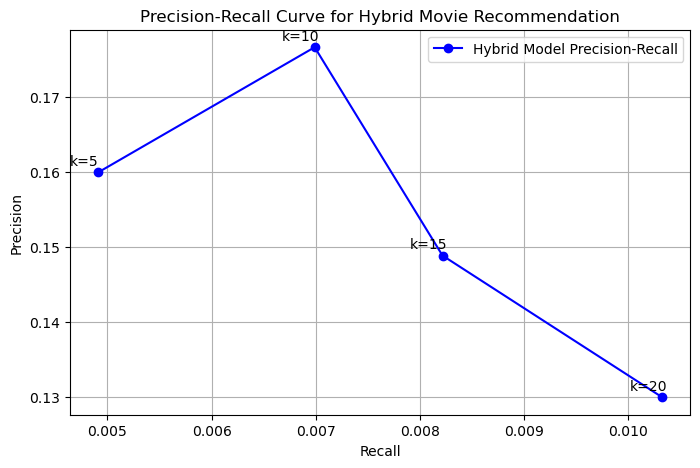

In [18]:
# Plot Precision-Recall Curve
plt.figure(figsize=(8, 5))
plt.plot(recall_scores, precision_scores, marker='o', linestyle='-', color='b', label="Hybrid Model Precision-Recall")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Hybrid Movie Recommendation")
plt.grid(True)

# Annotate k values on the plot
for i, k in enumerate(k_values):
    plt.annotate(f"k={k}", (recall_scores[i], precision_scores[i]), textcoords="offset points", xytext=(-10,5), ha='center')

plt.legend()
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_hybrid_rmse(test_users, user_item_matrix, item_similarity_df, svd, alpha=0.5):
    actual_ratings = []   # Initialize as an empty list
    predicted_ratings = [] # Initialize as an empty list

    for user_id in test_users:
        if user_id not in user_item_matrix.index:
            continue

        user_actual = ratings_df[ratings_df['userId'] == user_id][['movieId', 'rating']]
        
        for movie_id, actual_rating in zip(user_actual['movieId'], user_actual['rating']):
            # Skip if movie_id is missing in item_similarity_df
            if movie_id not in item_similarity_df.columns:
                continue

            # Content-based score (cosine similarity)
            content_score = item_similarity_df[movie_id].dot(user_item_matrix.loc[user_id]) / (item_similarity_df[movie_id].sum() + 1e-5)

            # Collaborative filtering score (SVD prediction)
            pred = svd.predict(user_id, movie_id).est

            # Hybrid Score
            hybrid_score = alpha * content_score + (1 - alpha) * pred

            predicted_ratings.append(hybrid_score)
            actual_ratings.append(actual_rating)

    if not actual_ratings:
        print("No valid test data for RMSE computation.")
        return None, None  # Ensure function still returns two values

    # Compute RMSE and MAE
    mse = mean_squared_error(actual_ratings, predicted_ratings)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual_ratings, predicted_ratings)

    print(f"--- Hybrid Model Evaluation ---")
    print(f"Hybrid MAE: {mae:.4f}")
    print(f"Hybrid MSE: {mse:.4f}")
    print(f"Hybrid RMSE: {rmse:.4f}\n")

    return mse, rmse


In [20]:
np.random.seed(42)
test_users = np.random.choice(ratings_df['userId'].unique(), size=10, replace=False)

alpha_values = [0.1, 0.3, 0.5, 0.7, 0.9]
rmse_scores = []

for alpha in alpha_values:
    _, rmse = evaluate_hybrid_rmse(test_users, user_item_matrix, item_similarity_df, svd, alpha)
    if rmse is not None:
        rmse_scores.append(rmse)

# Find best alpha
best_alpha = min(zip(alpha_values, rmse_scores), key=lambda x: x[1])[0]  
print(f"Optimal Alpha: {best_alpha}")


--- Hybrid Model Evaluation ---
Hybrid MAE: 0.6081
Hybrid MSE: 0.5400
Hybrid RMSE: 0.7348

--- Hybrid Model Evaluation ---
Hybrid MAE: 1.0302
Hybrid MSE: 1.3535
Hybrid RMSE: 1.1634

--- Hybrid Model Evaluation ---
Hybrid MAE: 1.5640
Hybrid MSE: 2.9273
Hybrid RMSE: 1.7109

--- Hybrid Model Evaluation ---
Hybrid MAE: 2.1484
Hybrid MSE: 5.2612
Hybrid RMSE: 2.2937

--- Hybrid Model Evaluation ---
Hybrid MAE: 2.7438
Hybrid MSE: 8.3553
Hybrid RMSE: 2.8906

Optimal Alpha: 0.1


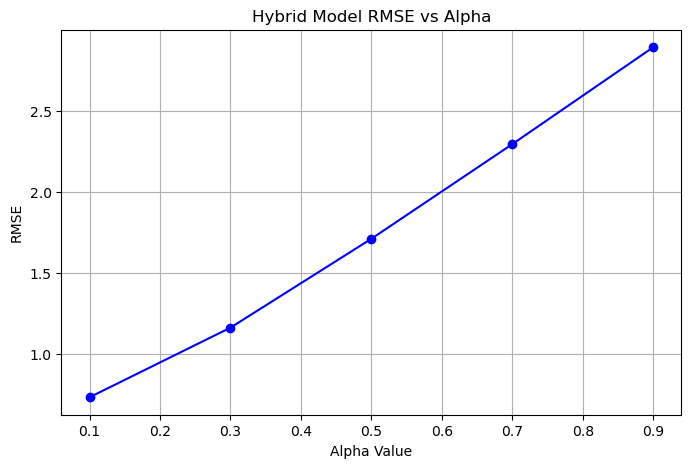

In [21]:
# Plot RMSE vs. Alpha
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, rmse_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Alpha Value")
plt.ylabel("RMSE")
plt.title("Hybrid Model RMSE vs Alpha")
plt.grid(True)
plt.show()